# Table of contents
1. [Preliminaries](#preliminaries)
2. [Coding PCA](#coding)
3. [Obtaining principal components](#components)
4. [Performing Gradient Boosting Classification with principal components](#classification1)

In this notbook I'm using the Diabetes Health Indicators Dataset https://www.kaggle.com/datasets/julnazz/diabetes-health-indicators-dataset downloaded from Kaggle. I take up a classification task, where I'm using ther Gradeint Boosting Classifier to predict whether a patient has diabetes or not. But first, I aim to reduce the dimensinality of features. I code the Principal Components Analysis and find lower dimensional subspaces of features.

# Preliminaries <a name="preliminaries"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import math
import matplotlib.pyplot as plt
from numpy import linalg as LA

# model

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# model validation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, make_scorer


import warnings
warnings.filterwarnings('ignore')  # Possibilities: "error", "ignore", "always", "default", "module" or "once"

np.int = int
np.bool= bool


In [2]:
path = "/content/drive/MyDrive/diabetes_binary_5050split_health_indicators_BRFSS2021.csv"

In [3]:
data = pd.read_csv(path)

In [4]:
pd.set_option('display.max_columns', None)
data.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000
mean,0.500000,0.548320,0.500238,0.976227,30.288340,0.440151,0.058866,0.136633,0.717260,0.605919,0.810608,0.049109,0.967260,0.066522,2.774756,4.230845,5.136752,0.231202,0.493431,8.501743,5.035912,6.563885
std,0.500004,0.497663,0.500004,0.152341,7.095737,0.496409,0.235375,0.343462,0.450334,0.488656,0.391822,0.216098,0.177955,0.249194,1.073759,8.323138,9.593837,0.421605,0.499961,3.019624,0.981610,2.422641
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,5.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,4.000000,5.000000,0.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,11.000000


In [5]:
# Showing all columns:

pd.set_option('display.max_columns', None)

In [6]:
len(data.columns)

22

In [7]:
RANDOM = 41

In [8]:
# Using 200 samples for training:

data1 = data.sample(200,random_state=RANDOM, axis=0)

In [9]:
data1.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,0.515000,0.490000,0.500000,0.965000,30.110000,0.420000,0.060000,0.130000,0.745000,0.625000,0.795000,0.040000,0.965000,0.070000,2.715000,3.765000,3.475000,0.21000,0.480000,8.455000,5.045000,6.695000
std,0.501029,0.501154,0.501255,0.184241,6.590529,0.494797,0.238083,0.337147,0.436955,0.485338,0.404715,0.196451,0.184241,0.255787,0.958315,8.016928,7.778296,0.40833,0.500854,3.065118,0.947345,2.500648
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,6.000000,4.000000,5.000000
50%,1.000000,0.000000,0.500000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,9.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,1.000000,33.250000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,0.00000,1.000000,11.000000,6.000000,9.000000
max,1.000000,1.000000,1.000000,1.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.00000,1.000000,13.000000,6.000000,11.000000


The sample of 200 patients is still balanced (the mean is almost the same as for the full dataframe), so this is good for training.

# Coding PCA  <a name="coding"></a>

Now I focus on the classification task, using xboost random forest. There are 22 columns, so the features live in a 22 dimensional space. I will reduce dimensionality by coding the PCA procedure by hand and picking a smaller dimensional subspace. Then I perform classification. Finally, I will perfrom the classification using all 22 features and will compare corectness of the two approaches.



In [10]:
# Dropping 'diabetes_binary' column:

X1 = data1.drop(['Diabetes_binary'], axis = 1)

In [11]:
len(data.columns)

22

In [12]:
# Normalizing the data:

# 1. Computing the mean for each column:

def mean(x):
    return sum(x)/len(x)

# 2. Computing standard deviation:

def st_dev(x):
    vec = ((np.array(x)-[mean(x)]*len(x)))**2;
    return math.sqrt(sum(vec)/len(x))

# 3. Computing the standardized vector:

def vec_to_normal(x):
    vec1 = (x-([mean(x)]*len(x)))/st_dev(x)
    return vec1


In [13]:
# Normalizing the data 2-dimensional array:

def standard_data(Y):
    StandardY = np.zeros_like(Y);
    for i in range(len(Y.columns)):
        StandardY[:,i] = vec_to_normal(Y.iloc[:, i])
    return pd.DataFrame(StandardY)


In [14]:
# Applying the standardizer to the features:

StandardData =  pd.DataFrame(standard_data(X1).copy())

Now each of the features is normalized. For example, looking at the description below, the mean is zero a d standard deviation is 1:

In [15]:
StandardData.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-0.980196,-1.0,0.190445,-1.233642,1.175139,-0.252646,-0.386556,0.585049,0.774597,-1.969276,-0.204124,0.190445,-0.274352,-0.747974,-0.470810,-0.447877,-0.515580,1.040833,-0.475887,-0.04762,1.324974
1,1.020204,1.0,0.190445,-0.168846,-0.850963,-0.252646,-0.386556,0.585049,-1.290994,-1.969276,-0.204124,0.190445,-0.274352,0.298143,-0.470810,-0.190106,-0.515580,1.040833,0.505324,-0.04762,0.924074
2,1.020204,-1.0,0.190445,-0.929414,1.175139,-0.252646,-0.386556,0.585049,-1.290994,0.507801,-0.204124,0.190445,-0.274352,0.298143,-0.470810,-0.447877,-0.515580,-0.960769,1.486535,1.01061,0.122274
3,1.020204,1.0,0.190445,-0.168846,-0.850963,-0.252646,-0.386556,0.585049,0.774597,0.507801,-0.204124,0.190445,-0.274352,0.298143,-0.470810,-0.447877,-0.515580,1.040833,0.832394,-0.04762,0.122274
4,-0.980196,-1.0,0.190445,1.504404,1.175139,-0.252646,-0.386556,-1.709260,0.774597,0.507801,4.898979,0.190445,-0.274352,0.298143,3.280663,-0.447877,1.939563,-0.960769,0.505324,1.01061,-1.080425


 Now we can define the covariance matrix:

In [16]:
def Covariance(Y):
    Cov = np.zeros((len(Y.columns), len(Y.columns)))
    for i in range(len(Y.columns)):
        for j in range(len(Y.columns)):
            Cov[i,j] = np.dot(Y.iloc[:,i],Y.iloc[:,j])
    return Cov

Obtaining a 21x21 covariance matrix for our case:

In [17]:
Cov = Covariance(StandardData)

In [18]:
# Finding eigenvalues of the Covariance matrix:

eigenvalues, eigenvectors = np.linalg.eig(Cov)
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices for descending order
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

Usually one can see when the magnitude of eigenvalues drops dramatically:

In [19]:
eigenvalues

array([642.70373742, 479.84673675, 327.93831303, 264.28591267,
       250.23848965, 234.0564618 , 220.82985088, 200.58439859,
       177.10319061, 171.79187635, 159.17549624, 150.38796347,
       138.24999102, 125.60779805, 118.40691099, 112.36617747,
       102.89080617,  89.62228409,  87.08151745,  74.45112692,
        72.38096041])

For example, the difference in magnitude between the top eigenvalue ans the 20th one:

In [20]:
print(f"The difference in scale between the first and last eigenvalue is {eigenvalues[0]/eigenvalues[20]}.")

The difference in scale between the first and last eigenvalue is 8.87945854547477.


Plotting the histogram of eigenvalues:


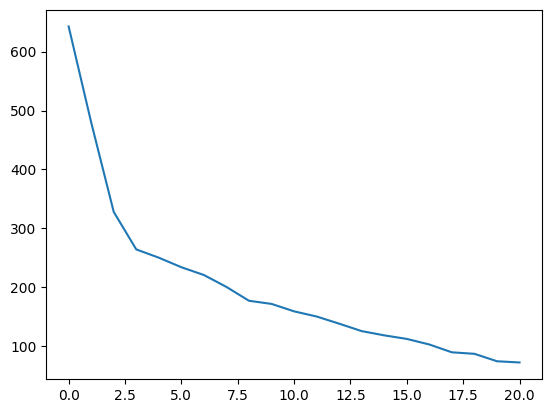

In [21]:
xpoints = np.array([i for i in range(len(eigenvalues))])
plt.plot(xpoints, eigenvalues)
plt.show()

Plotting the histogram of three first eigenvalues:


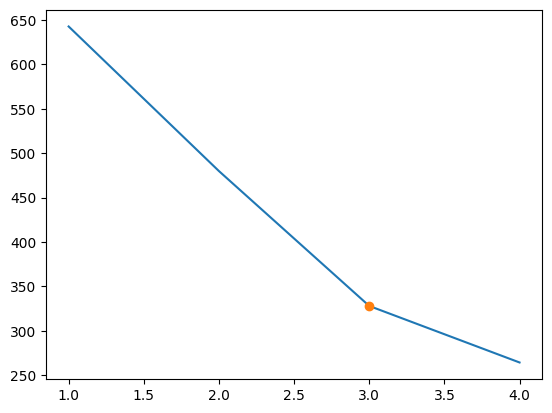

In [22]:
xpoints = np.array([1,2,3,4])
plt.plot(xpoints, eigenvalues[:4])
plt.plot(xpoints[2], eigenvalues[2], 'o')
plt.show()

We see, we may just need three principal vectors, with the frist one completely dominating.

# Obtaining principal components <a name="components"></a>

The last step is to project our standardized data set onto the subspace spanned by the three eigenvectors we chose!

In [23]:
PCAdata = pd.DataFrame(np.dot(StandardData,eigenvectors[:,:3]))

In [24]:
PCAdata

,0,1,2
0,1.951845,0.964257,1.011420
1,0.321842,-0.774702,0.399359
2,0.519976,-0.745374,0.223715
3,0.661796,-1.351696,0.521584
4,-1.422363,0.765906,-2.284479
...,...,...,...
195,1.831725,1.171609,-0.439744
196,0.284848,0.324721,-0.235361
197,0.359354,-0.232489,-0.353795
198,-0.774365,-0.992293,0.452622


# Performing Gradient Boosting Classification with three principal components <a name="classification1"></a>

Using just three principal components in the binary classification task:

In [25]:
# Creating a new data frame with three features:

XPCA = pd.DataFrame(PCAdata)
y = data1['Diabetes_binary'].values

In [26]:
XPCA

,0,1,2
0,1.951845,0.964257,1.011420
1,0.321842,-0.774702,0.399359
2,0.519976,-0.745374,0.223715
3,0.661796,-1.351696,0.521584
4,-1.422363,0.765906,-2.284479
...,...,...,...
195,1.831725,1.171609,-0.439744
196,0.284848,0.324721,-0.235361
197,0.359354,-0.232489,-0.353795
198,-0.774365,-0.992293,0.452622


In [27]:
RANDOM_STATE = 1

In [28]:
X_train, X_test, y_train, y_test = train_test_split(XPCA, y, test_size=0.33, random_state = RANDOM_STATE)

In [29]:
# check size of data splits:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(134, 3)
(66, 3)
(134,)
(66,)


# Defining and running the pipeline for the Gradient Boosting Classifier with three principal components (extreme dimensionality reduction):

In [30]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
clf1 = clf.fit(X_train, y_train)

In [31]:
# Defining metrics of the model: the score and confusion matrix:

def Metrics(predictions):
    print(f'the score on the training set set is ' +str(clf.score(X_train,y_train)) )
    print(f'the score on the test set set is ' +str(clf.score(X_test,y_test)) )
    print(classification_report(y_test,predictions, digits=5))
    conf=confusion_matrix(y_test,predictions,normalize='all')
    displayCM=ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=clf.classes_)
    displayCM.plot()

In [32]:
predictions = clf.predict(X_test)

the score on the training set set is 1.0
the score on the test set set is 0.7121212121212122
              precision    recall  f1-score   support

         0.0    0.72414   0.65625   0.68852        32
         1.0    0.70270   0.76471   0.73239        34

    accuracy                        0.71212        66
   macro avg    0.71342   0.71048   0.71046        66
weighted avg    0.71310   0.71212   0.71112        66



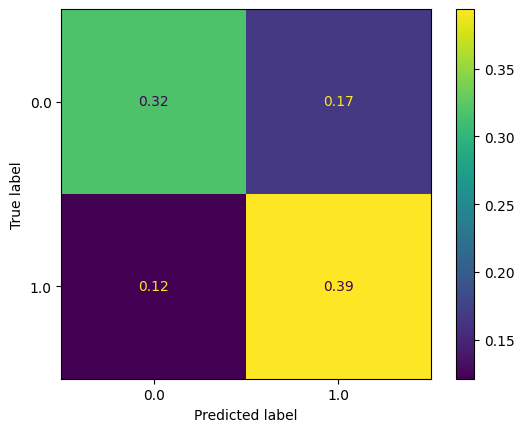

In [33]:
Metrics(predictions)

Given that we reduced the feature space by 85.71% (we only used three features and the starting point was twenty one features), getting 71% accuracy is a very good result!